# Tutorial Ptychographic imaging

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) /  email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

##### Disclaimer: This notebook is intended from educational reasons only and should not be use for professional data analysis. For the latter, there are other more efficient and complete codes available.

This code run in **Python3** and requires certain python packages, which are: **Numpy, IPython, Matplotlib, Scikit-Image**

If you do not have those packages, I suggest their installation via pip install: 

    pip3 install numpy, ipython, matplotlib, scikit-image

# Ptychographic phase retrieval
This code is deeply inspired by the MATLAB code available in the Appendix A of the Diploma thesis by Dr. Martin Dierolf, which is available here: https://www.psi.ch/sls/csaxs/PublicationsEN/thesis_dierolf.pdf

In [1]:
%matplotlib inline
# standard python package
import time 

# third party packages
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from skimage.io import imread
from skimage.transform import resize

## Experimental Settings
This part set the value of the aperture, the amount of overlap and the scanning step

In [2]:
d=8.5e-6#12e-6 # diameter of aperture
overlap = 0.5# amount of overlapping
apshift = d*(1-overlap) # distance between the aperture positions
energy = 12.4 # in keV
wavelen = (12.4e-10/energy) # in m
z = 10 # distance of propagation in m

## Loading image data

We will use a fluorescence image of a cell obtained from http://rsb.info.nih.gov/ij/images/FluorescentCells.jpg.
If you have internet connection, you can download the data from the website (method 1 below), otherwise, you can use the local file named "**FluorescentCells_201.jpg**" (method 2 below).

In [3]:
## method 1: load image from file
image = plt.imread('FluorescentCells_201.jpg')
## method 2: if you have access to internet, you can access it directly from URL
#image = imread("http://rsb.info.nih.gov/ij/images/FluorescentCells.jpg")
#image = resize(image,(201,201)) #Image resized to 201x201 pixel

# convert to HSV color scheme
image_hsv = color.rgb2hsv(image)

# creating amplitude and phase
datamp = np.squeeze(image_hsv[:,:,2])
datphase = 2*np.pi*np.squeeze(image_hsv[:,:,0])-np.pi
#dat = np.flipud(datamp*np.exp(1j*datphase))
dat = np.flipud(datamp*np.exp(1j*datphase))

## Defining pixel size, length and source coordinates arrays

In [4]:
# let us suppose we want a pixel size of 100 nm
dx = 95e-9 # pixel size in meter
M = image.shape[0] # number of pixels (supposing image is square)
L = M*dx # width of the object
x = np.arange(-L/2,L/2,dx) # source coordinates  #L/201) #np.arange(0,201)
if x.shape[0]== M+1: x = x[:-1] # small correction for floating number rounding
y = x # equal in both directions
det_pixel = wavelen*z/L # detector pixel size for this simulation

# Diplay original data in HSV representation

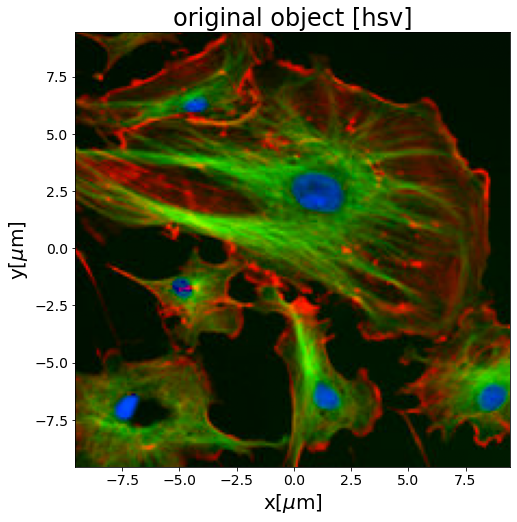

In [5]:
plt.close('all')
fig1 = plt.figure(1,figsize=(8,8))
plt.clf()
ax1 = fig1.add_subplot(111)
dathsv = np.zeros((dat.shape[0],dat.shape[1],3))
dathsv[:,:,0] = (np.angle(dat)+np.pi)/(2*np.pi)
dathsv[:,:,1] = np.ones((dat.shape[0],dat.shape[1]))
dathsv[:,:,2] = np.abs(dat)
ax1.imshow(color.hsv2rgb(dathsv),extent= [x.min()*1e6,x.max()*1e6,y.min()*1e6,y.max()*1e6])
ax1.set_title('original object [hsv]',fontsize=24)
ax1.tick_params(axis='both',which='major',labelsize=14)
ax1.set_xlabel(r'x[$\mu$m]',fontsize = 20)
ax1.set_ylabel(r'y[$\mu$m]',fontsize = 20)
plt.show(block=False)

## Sampling requirements
Let us now check if the the **sampling requirements** have been respected:

In [6]:
print('Sampling pitch should be smaller than {:0.02f} microns'.format(1e6*wavelen*z/(2*d))) # how small the detector pixel should be
print('The detector pixel size is {:0.02f} microns'.format(1e6*det_pixel))

# sampling the joint real-reciprocal phase space of ptychography
alpha = apshift/d # filling of the real space 
beta = (det_pixel*d)/(wavelen*z) # filling of the reciprocal space
sampling_ratio = 1/(alpha*beta) # filling of the phase space (joint real-reciprocal space) without gap
print('Alpha = {:0.04f}. It must be smaller than 1.'.format(alpha))
print('Beta = {:0.04f}. It must be smaller than 1.'.format(beta))
print('The sampling ratio is {:0.04f}. It must be larger than 2 in general.'.format(sampling_ratio))

Sampling pitch should be smaller than 58.82 microns
The detector pixel size is 52.37 microns
Alpha = 0.5000. It must be smaller than 1.
Beta = 0.4451. It must be smaller than 1.
The sampling ratio is 4.4929. It must be larger than 2 in general.


Also note that **Beta = 0.5** corresponds to the CDI oversampling rule of having at least two pixels per speckle. Althought it should not work for CDI, a Beta larger than 0.5 (and smaller thant 1) can work for ptychography, given that the **sampling ratio** is still larger than 2. 

# Defining the 9 positions for PIE simulations

In [7]:
xp,yp = np.zeros((2,9))
xp[0] = -(apshift)
xp[1] = +(apshift)
xp[2] = 0
xp[3] = 0
xp[4] = -(apshift)
xp[5] = -(apshift)
xp[6] = +(apshift)
xp[7] = +(apshift)
xp[8] = 0
yp[0] = 0
yp[1] = 0
yp[2] = +(apshift)
yp[3] = -(apshift)
yp[4] = -(apshift)
yp[5] = +(apshift)
yp[6] = +(apshift)
yp[7] = -(apshift)
yp[8] = 0

# Creating an illumination function as unpropagated waves from a pinhole

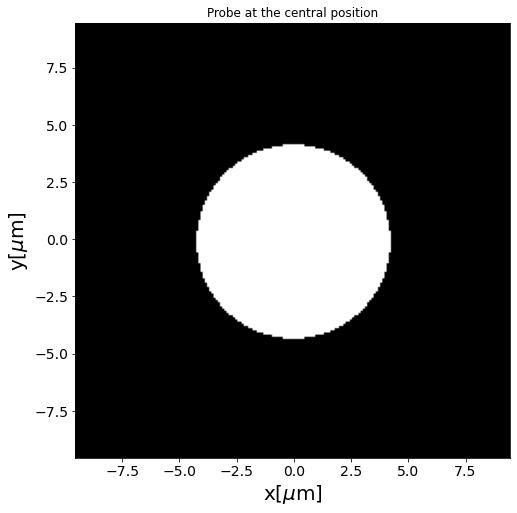

In [8]:
def illumination(X,Y,xp,yp):
    """
    Function to create a round aperture
    """
    rad = np.sqrt((X-xp)**2+(Y-yp)**2)
    p = np.zeros_like(rad)
    p[np.where(rad<d/2.0)]=1.0
    p[np.where(rad==d/2.0)]=0.5
    return p

X,Y = np.meshgrid(x,y)
probe0 = illumination(X,Y,0,0) # probe at the center to initialize array
probe = np.zeros((xp.shape[0],probe0.shape[0],probe0.shape[1])).astype(np.complex)

# creating the probes at the scan positions
for ii in range(xp.shape[0]):
    probe[ii] = illumination(X,Y,xp[ii],yp[ii]).astype(np.complex)

# Display the probe at the center
fig2 = plt.figure(2,figsize=(8,8))
ax2 = fig2.add_subplot(111)
im2 = ax2.imshow(probe0,cmap='gray',extent = [x.min()*1e6,x.max()*1e6,y.min()*1e6,y.max()*1e6])
ax2.tick_params(axis='both',which='major',labelsize=14)
ax2.set_xlabel(r'x[$\mu$m]',fontsize = 20)
ax2.set_ylabel(r'y[$\mu$m]',fontsize = 20)
plt.title('Probe at the central position')
plt.show(block=False)

# Simulating diffraction patterns

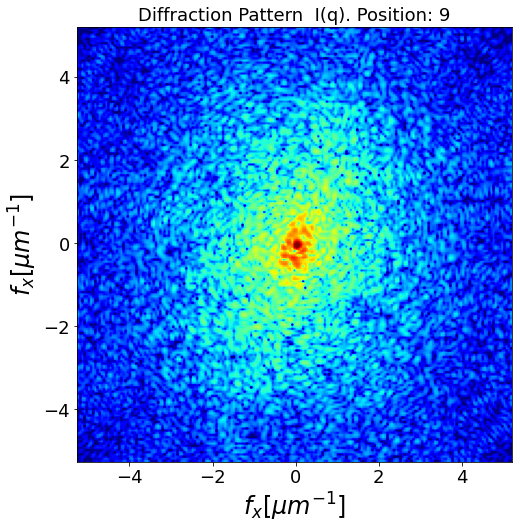

In [9]:
## settings of the Fourier space
fx = np.arange(-1/(2*dx),1/(2*dx),1/L) # Fourier space frequencies (1/L=det_pixel/(wavelen*z))
fy = fx # supposing square diffraction patterns

# initializing variables
img0 = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe[0]*dat))) # first image to obtain size
dp_exp = np.zeros((xp.shape[0],img0.shape[0],img0.shape[1])) # diffration pattern array

# preparing figure canvas
eps=0.1 # small quantity to prevent 0 in the logarithm
fig3 = plt.figure(3,figsize = (8,8))
ax3 = fig3.add_subplot(111)
im3 = ax3.imshow(np.log(np.abs(img0**2+eps)),extent=[np.min(fy)*1e-6,np.max(fy)*1e-6,np.min(fy)*1e-6,np.max(fy)*1e-6],cmap='jet',vmin=0)
ax3.set_xlabel(r'$f_x [\mu m^{-1}$]',fontsize = 24)
ax3.set_ylabel(r'$f_x [\mu m^{-1}$]',fontsize = 24)
ax3.tick_params(axis='both',which='major',labelsize=18)
# loop over the 9 positions
for ii in range(xp.shape[0]):
    psi = probe[ii]*dat
    sim = np.fft.fft2(np.fft.fftshift(psi))
    dp_exp[ii] = np.abs(sim)
    amplitudes=np.fft.ifftshift(dp_exp[ii])
    ints=np.abs(amplitudes)**2
    im3.set_data(np.log(ints+eps))
    ax3.set_title('Diffraction Pattern  I(q). Position: {}'.format(ii+1),fontsize=18)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.5)

We can see that the Nyquist frequency is $f_{Nyquist}= \frac{1}{2 \Delta x}$, and thus the pixel size of the reconstructed image $\Delta x$ in the real scape will be $\Delta x = \frac{1}{2 f_{Nyquist}}$. This is also equivalent to $\Delta x = \frac{\lambda z}{M \Delta p_{det}}$, where $\lambda$ is the wavelength, z is the propagation distance, and $\Delta p_{det}$ is the physical detector pixel size.

In [10]:
fNyquist = 1/(2*dx) # Nyquist Frequency
print(r"The Nyquist frequency is {:0.01f} inverse microns".format(fNyquist*1e-6))
# calculate the pixel size of the reconstructed image
dxrecons1 = 1/(2*fNyquist) # method 1
dxrecons2 = wavelen*z/(M*det_pixel) # method 2
print("The pixel size of the reconstruction is (as expected):")
print('dxrecons1 = {:0.01e} and dxrecons2 = {:0.01e}'.format(dxrecons1,dxrecons2))
print('which is the pixel size we have chosen at the beggining for this simulation')

The Nyquist frequency is 5.3 inverse microns
The pixel size of the reconstruction is (as expected):
dxrecons1 = 9.5e-08 and dxrecons2 = 9.5e-08
which is the pixel size we have chosen at the beggining for this simulation


## The Ptychographic Iterative Engine (PIE)

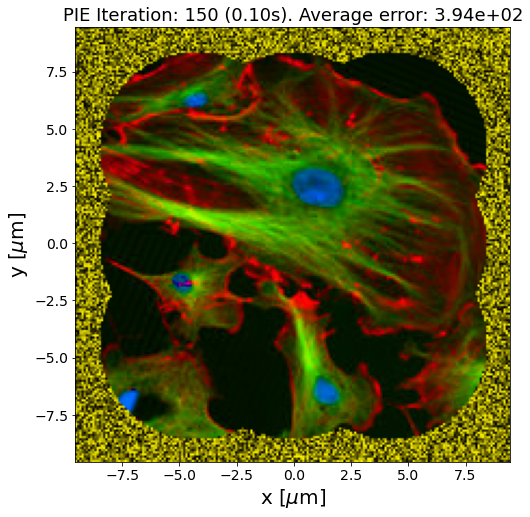

In [11]:
plt.close('all')
# settings for the PIE
numIter = 150 # number of PIE loops
eps = 1e-4 # Paramenter that control the stability of the algorithm
ferr = 1 # Parameter of the error function

## initial guess for object
np.random.seed(1) # to keep the same seed if you run the code twice
obj_sample = np.random.rand(image.shape[0],image.shape[1]).astype(np.complex)
# uncomment the line below if you want to initialize obj with ones
#obj_sample = np.ones((image.shape[0],image.shape[1])).astype(np.complex)

## Ptychographic Iterative Engine (PIE) loop
err = np.zeros(xp.shape[0])
avgerr = np.zeros(numIter)
fig4 = plt.figure(4,figsize=(8,8))
ax4 = fig4.add_subplot(111)
r,c,z = dathsv.shape
objecthsv = np.zeros((obj_sample.shape[0],dat.shape[1],3))
im4 = ax4.imshow(color.hsv2rgb(objecthsv),extent= [x.min()*1e6,x.max()*1e6,y.min()*1e6,y.max()*1e6])
ax4.tick_params(axis='both',which='major',labelsize=14)
ax4.set_xlabel(r'x [$\mu$m]',fontsize = 20)
ax4.set_ylabel(r'y [$\mu$m]',fontsize = 20)
for ii in range(numIter):
    t0 = time.time()
    ## loop over the 9 positions
    for pos in range(xp.shape[0]):
        # multiply probe and sample
        obj = probe[pos]*obj_sample
        #------------------------
        objnew = np.fft.ifft2(dp_exp[pos]*np.exp(1j*np.angle(np.fft.fft2(obj)))) # amplitude constraint
        #------------------------
        deno = np.conj(probe[pos])*probe[pos]+eps
        update_function = np.conj(probe[pos])*np.abs(probe[pos])/deno # update function
        #------------------------
        object_new = obj_sample + ferr*update_function*(objnew-obj) # overlap constraint
        obj_sample = object_new
        #------------------------
        err[pos] = np.sum(dp_exp[pos]**2 - (np.abs(np.fft.fft2(obj)))**2)**2/(image.shape[0]**2)
    tf = time.time()
    avgerr[ii] = err.mean() #calculate average error
    ## display retrieved object in hsv representation
    objecthsv[:,:,0] = (np.angle(obj_sample*np.exp(1j*1*np.pi))+np.pi+1)/(2*np.pi)
    objecthsv[:,:,1] = np.ones((obj_sample.shape[0],obj_sample.shape[1]))
    objecthsv[:,:,2] = np.abs(obj_sample) - (0.5+0.5*np.sign(np.abs(obj_sample)-1))*(np.abs(obj_sample)-1)
    im4.set_data(color.hsv2rgb(objecthsv))
    ax4.set_title('PIE Iteration: {} ({:0.02f}s). Average error: {:0.02e}'.format(ii+1,tf-t0,avgerr[ii]),fontsize = 18)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.0001)

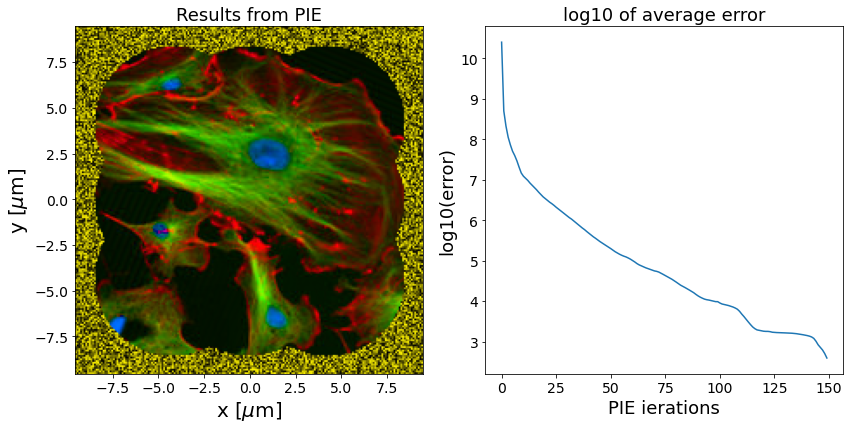

In [12]:
# plot result and errors
fig5 = plt.figure(5,figsize=(12,6))
ax51 = fig5.add_subplot(121)
ax51.imshow(color.hsv2rgb(objecthsv),extent= [x.min()*1e6,x.max()*1e6,y.min()*1e6,y.max()*1e6])
ax51.set_title('Results from PIE',fontsize=18)
ax51.set_xlabel(r'x [$\mu$m]',fontsize = 20)
ax51.set_ylabel(r'y [$\mu$m]',fontsize = 20)
ax51.tick_params(axis='both',which='major',labelsize=14)
ax52 = fig5.add_subplot(122)
ax52.plot(np.log10(avgerr))
ax52.set_title('log10 of average error',fontsize=18)
ax52.set_xlabel('PIE ierations',fontsize = 18)
ax52.set_ylabel('log10(error)',fontsize = 18)
ax52.tick_params(axis='both',which='major',labelsize=14)
plt.tight_layout()
plt.show(block=False)

## Congratulations, you have performed the simulation of a ptychography experiment. Well done!